## MultiClass Logistic Regression

A logistic regression where the target variable have more than 2 possible outcomes :)

The main difference is that it uses Softmax function instead of the Sigmoid function.

Read all about it [here](https://dataaspirant.com/difference-between-softmax-function-and-sigmoid-function/).

### Business Case
We'll be using the bank database to predict the status of each loan, taking into account all the transactions

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


### Get the data

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''
        select t.type, t.operation, t.amount as t_amount, t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status
        from trans t
        join loan l
        on t.account_id = l.account_id;
        '''

data = pd.read_sql_query(query, engine)
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A
...,...,...,...,...,...,...,...,...,...
156076,PRIJEM,,67.9,17036.9,UROK,268320,60,4472.0,C
156077,PRIJEM,,187.2,42249.6,UROK,437460,60,7291.0,C
156078,PRIJEM,,132.0,31046.4,UROK,272520,60,4542.0,C
156079,PRIJEM,,271.6,58694.2,UROK,380160,60,6336.0,C


In [3]:
pd.read_sql_table('loan', engine) # if you want the whole table

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A
...,...,...,...,...,...,...,...
677,4989,105,981205,352704,48,7348.0,C
678,5221,1284,981205,52512,12,4376.0,C
679,6402,6922,981206,139488,24,5812.0,C
680,5346,1928,981206,55632,24,2318.0,C


In [4]:
pd.read_sql_table('distinct_users', engine) # it also works on views

,Active_id,Activity_year,Activity_month
0,9,1993,01
1,163,1993,01
2,192,1993,01
3,212,1993,01
4,280,1993,01
...,...,...,...
183359,11333,1998,12
183360,11349,1998,12
183361,11359,1998,12
183362,11362,1998,12


### Check the data

In [5]:
data['status'].value_counts()

C    72288
A    64599
B     9765
D     9429
Name: status, dtype: int64

In [6]:
data.shape

(156081, 9)

In [7]:
data.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration       int64
payments     float64
status        object
dtype: object

In [8]:
data.describe()

,t_amount,balance,l_amount,duration,payments
count,156081.000000,156081.000000,156081.000000,156081.000000,156081.000000
mean,7795.357503,45353.630156,146822.230995,35.598209,4189.309205
std,11707.393031,25028.806295,109974.568837,17.189519,2198.565442
min,0.000000,-19310.000000,4980.000000,12.000000,304.000000
25%,144.100000,27291.700000,65184.000000,24.000000,2482.000000
50%,2800.000000,40649.500000,111384.000000,36.000000,3900.000000
75%,9902.000000,59162.000000,203940.000000,48.000000,5900.000000
max,87300.000000,209637.000000,590820.000000,60.000000,9910.000000


In [9]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

### Clean the data

In [10]:
data = data[data['duration'].isna() == False] # dropna() is also a good option
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A
...,...,...,...,...,...,...,...,...,...
156076,PRIJEM,,67.9,17036.9,UROK,268320,60,4472.0,C
156077,PRIJEM,,187.2,42249.6,UROK,437460,60,7291.0,C
156078,PRIJEM,,132.0,31046.4,UROK,272520,60,4542.0,C
156079,PRIJEM,,271.6,58694.2,UROK,380160,60,6336.0,C


In [11]:
data['duration'] = data['duration'].astype('object') # treating duration as categorical

In [12]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

VYDAJ     91428
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64 

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64 

               73946
UROK           31337
SLUZBY         23592
SIPO           10482
UVER            7744
                5979
POJISTNE        2412
SANKC. UROK      589
Name: k_symbol, dtype: int64 

24    34141
12    32217
60    32042
48    29265
36    28416
Name: duration, dtype: int64 

C    72288
A    64599
B     9765
D     9429
Name: status, dtype: int64 



In [13]:
def cleanOperation(x):
    if len(x) < 2:
        return 'unknown'
    else:
        return x.lower()
# or
cleanOperation = lambda x: 'unknown' if len(x) < 2 else x.lower()

In [14]:
for col in ['operation', 'k_symbol']:
    data[col] = data[col].apply(cleanOperation)
    
# or: data = data.applymap(cleanOperation)

In [15]:
# checking how many different loans of each type and operation
pd.crosstab(data['type'], data['status'])

status,A,B,C,D
type,,,,
PRIJEM,23561,4099,27637,4009
VYBER,2214,415,2313,405
VYDAJ,38824,5251,42338,5015


### EDA

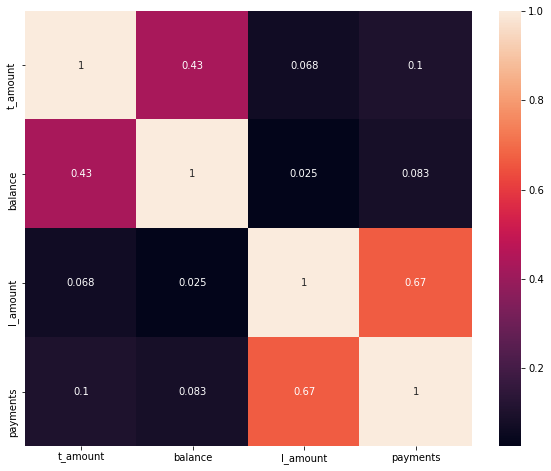

In [16]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

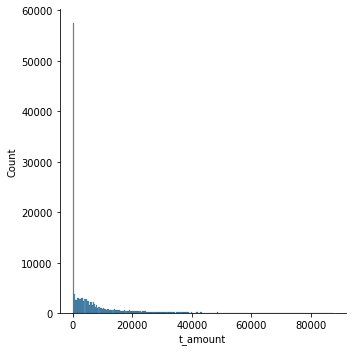

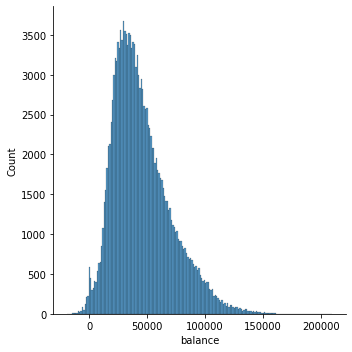

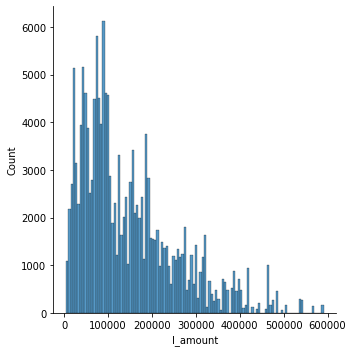

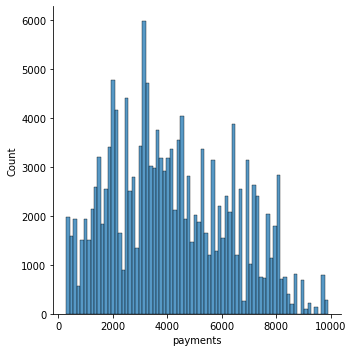

In [17]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

### Feature Engineering

#### Maybe log or boxcox transformation would make sense. Because of the high number of categorical columns and their likely importance, i'd avoid using Normalizer, since you'd loose some information on the categorical data.

In [18]:
### Activity 3

### Train the model

In [19]:
y = data['status']
X = data.drop('status', axis=1)

In [20]:
# watch out! rookie mistake: DONNUT dummify the target variable
X = pd.get_dummies(X)
X

,t_amount,balance,l_amount,payments,type_PRIJEM,type_VYBER,type_VYDAJ,operation_prevod na ucet,operation_prevod z uctu,operation_unknown,...,k_symbol_sipo,k_symbol_sluzby,k_symbol_unknown,k_symbol_urok,k_symbol_uver,duration_12,duration_24,duration_36,duration_48,duration_60
0,44749.0,45549.0,79608,3317.0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,1000.0,1000.0,52788,4399.0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1100.0,1100.0,21924,609.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,700.0,700.0,23052,1921.0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,900.0,900.0,41904,3492.0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156076,67.9,17036.9,268320,4472.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
156077,187.2,42249.6,437460,7291.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
156078,132.0,31046.4,272520,4542.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
156079,271.6,58694.2,380160,6336.0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
classification = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=500) # max_iter
classification.fit(X_train, y_train)
# here the model does not converge, to solve it you can scale the data or increase the max_iter parameter
# the first option will save on processing power.

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

### Evaluate the model

In [23]:
classification.score(X_test, y_test)

0.7060255629945222

In [24]:
predictions = classification.predict(X_test)

pd.Series(predictions).value_counts()

C    17710
A    12933
B      386
D      188
dtype: int64

In [25]:
y_test.value_counts()

C    14531
A    12876
B     1943
D     1867
Name: status, dtype: int64

OBS: the model amplifies the imbalance in the data

In [27]:
confusion_matrix(y_test, predictions)

array([[ 9413,    52,  3410,     1],
       [ 1106,   225,   595,    17],
       [ 2182,    41, 12270,    38],
       [  232,    68,  1435,   132]])

<AxesSubplot:>

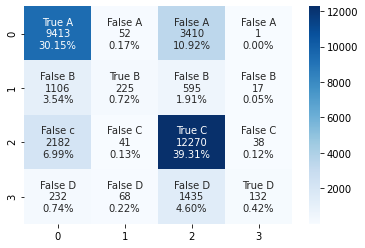

In [36]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True A', 'False A', 'False A', 'False A',
               'False B', 'True B', 'False B', 'False B',
               'False c', 'False C', 'True C', 'False C',
               'False D', 'False D', 'False D', 'True D']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

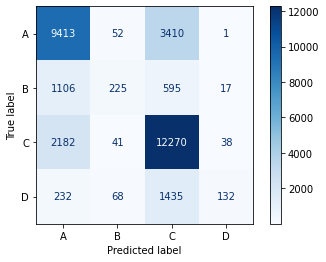

In [38]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

In [ ]:
# still hard to see how good the model is, considering the data imbalance

### Conclusions

* How good are my predictions?
* What am I actually predicting here? What do I want to achieve with these predictions?
* Have I chosen my data wisely? (garbage in - garbage out)
* Thoughts on how to improve the model?

### Homework: Prove to me that this model suck from it's conception.